In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from pydataset import data
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import prepare
import acquire
import ml_def 

from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

rng = np.random.RandomState(0)
np.random.seed(123)
N_SPLITS = 5


In [2]:
df = acquire.get_titanic_data()
df

Reading from csv file...


,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,0,2,male,27.0,0,0,13.0000,S,Second,NaN,Southampton,1
887,887,1,1,female,19.0,0,0,30.0000,S,First,B,Southampton,1
888,888,0,3,female,NaN,1,2,23.4500,S,Third,NaN,Southampton,0
889,889,1,1,male,26.0,0,0,30.0000,C,First,C,Cherbourg,1


In [3]:
def prep_titanic(df):
    df = df.drop_duplicates()
    df = df.drop(columns=['embarked', 'class', 'passenger_id','embark_town', 'embarked', 'parch'])
    df[['sex']] = df[['sex']].replace(to_replace="male",value="1")
    df[['sex']] = df[['sex']].replace(to_replace="female",value="0")
    return df


In [4]:
df = prep_titanic(df)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
alone,891.0,0.602694,0.489615,0.00,0.0000,1.0000,1.0,1.0000


In [6]:
print(df['survived'].value_counts())
print(f"Approximately {(df['survived'].value_counts()[0]/df['survived'].size*100):.4f}% that died ")
print(f"Approximately {(df['survived'].value_counts()[1]/df['survived'].size*100):.4f}% that survived.")



0    549
1    342
Name: survived, dtype: int64
Approximately 61.6162% that died 
Approximately 38.3838% that survived.


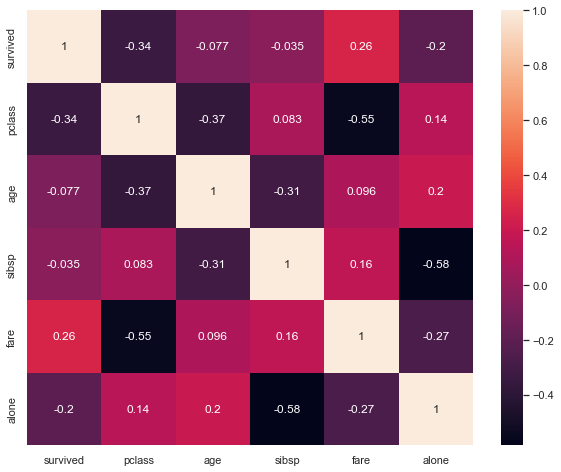

In [7]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(df.corr(), annot =True)
plt.show()

In [8]:
df.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'fare', 'deck', 'alone'], dtype='object')

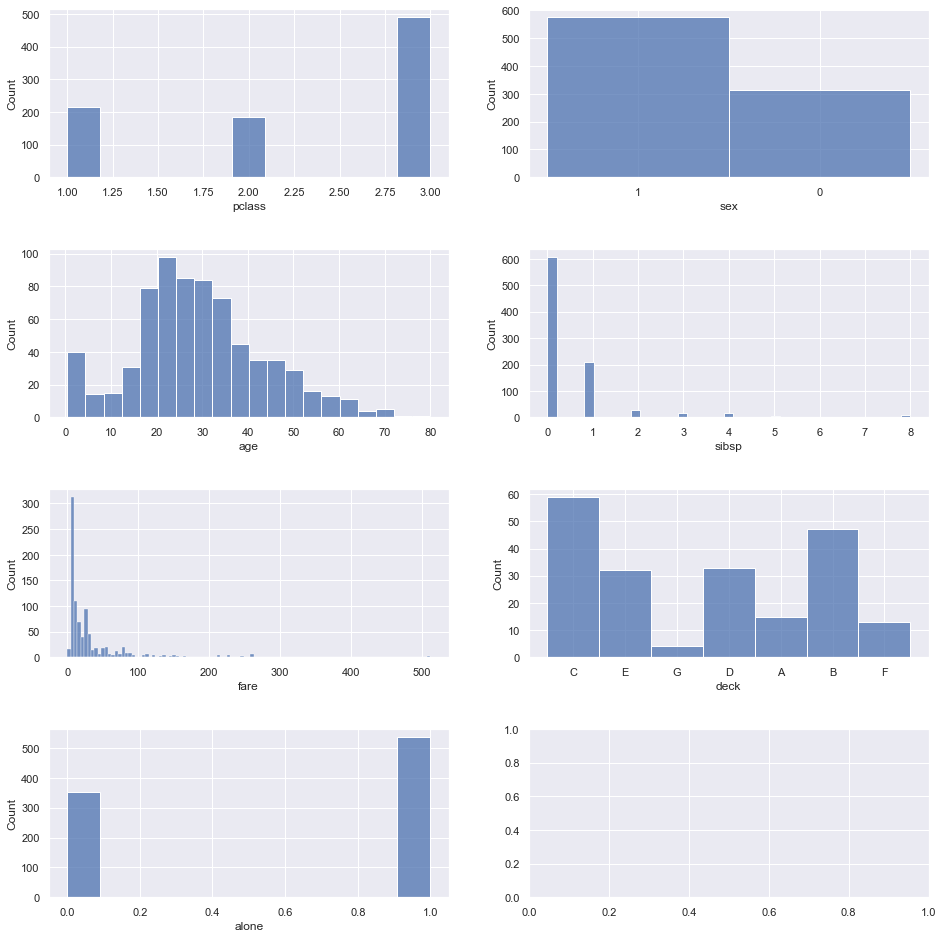

In [9]:
fig, axes = plt.subplots(4, 2, figsize=(14,14))
fig.tight_layout(pad=4.0)

for i,j in enumerate(df.columns[1:]):
    sns.histplot(df[j], ax=axes[i//2, i%2])
plt.show() 

In [10]:
ndf = df.copy(deep = True)
ndf

,survived,pclass,sex,age,sibsp,fare,deck,alone
0,0,3,1,22.0,1,7.2500,NaN,0
1,1,1,0,38.0,1,71.2833,C,0
2,1,3,0,26.0,0,7.9250,NaN,1
3,1,1,0,35.0,1,53.1000,C,0
4,0,3,1,35.0,0,8.0500,NaN,1
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,13.0000,NaN,1
887,1,1,0,19.0,0,30.0000,B,1
888,0,3,0,NaN,1,23.4500,NaN,0
889,1,1,1,26.0,0,30.0000,C,1


In [11]:
ndf[['deck']] = ndf[['deck']].replace(to_replace="A",value="1")
ndf[['deck']] = ndf[['deck']].replace(to_replace="B",value="2")
ndf[['deck']] = ndf[['deck']].replace(to_replace="C",value="3")
ndf[['deck']] = ndf[['deck']].replace(to_replace="D",value="4")
ndf[['deck']] = ndf[['deck']].replace(to_replace="E",value="5")
ndf[['deck']] = ndf[['deck']].replace(to_replace="F",value="6")
ndf[['deck']] = ndf[['deck']].replace(to_replace="G",value="7")

In [12]:
(ndf == 0).sum()


survived    549
pclass        0
sex           0
age           0
sibsp       608
fare         15
deck          0
alone       354
dtype: int64

In [13]:
ndf.isnull().sum()


survived      0
pclass        0
sex           0
age         177
sibsp         0
fare          0
deck        688
alone         0
dtype: int64

In [14]:
print(ndf.age)

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: age, Length: 891, dtype: float64


In [15]:
def gimmeThemStats(dFrame):
    """
    Description
    ----
    Outputs the general statistical description of the dataframe,
    outputs the correlation heatmap, and outputs a distribution plot.
    
    Parameters
    ----
    dFrame(DataFrame):
        The dataframe for which information will be displayed.
        
    Returns
    ----
    Nothing.
    
    """
    # Description
    print("Descriptive Stats:")
    display(dFrame.describe().T)
    
    # Heatmap
    plt.figure(figsize=(10, 8)) 
    plt.title("Heatmap", fontsize = 'x-large')
    sns.heatmap(dFrame.corr(), annot =True)
    
    # Distribution
    ### NOTE: I changed histplot to distplot
    fig, axes = plt.subplots(4, 2, figsize=(14,14))
    fig.suptitle("Distribution Plot", y=0.92, fontsize='x-large')
    fig.tight_layout(pad=4.0)

    for i,j in enumerate(df.columns[1:]):
        sns.distplot(dFrame[j], ax=axes[i//2, i%2])

Descriptive Stats:


,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
alone,891.0,0.602694,0.489615,0.00,0.0000,1.0000,1.0,1.0000


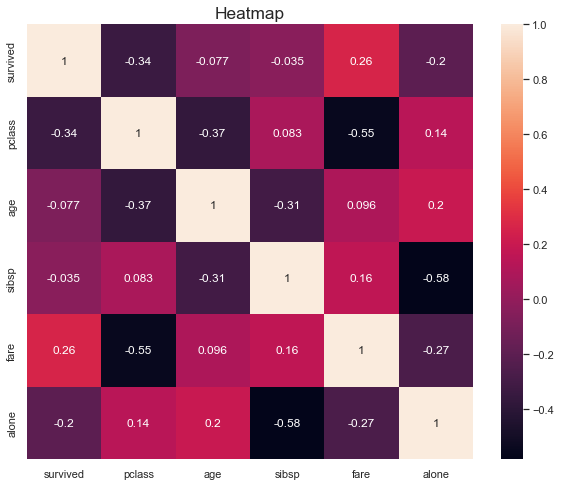

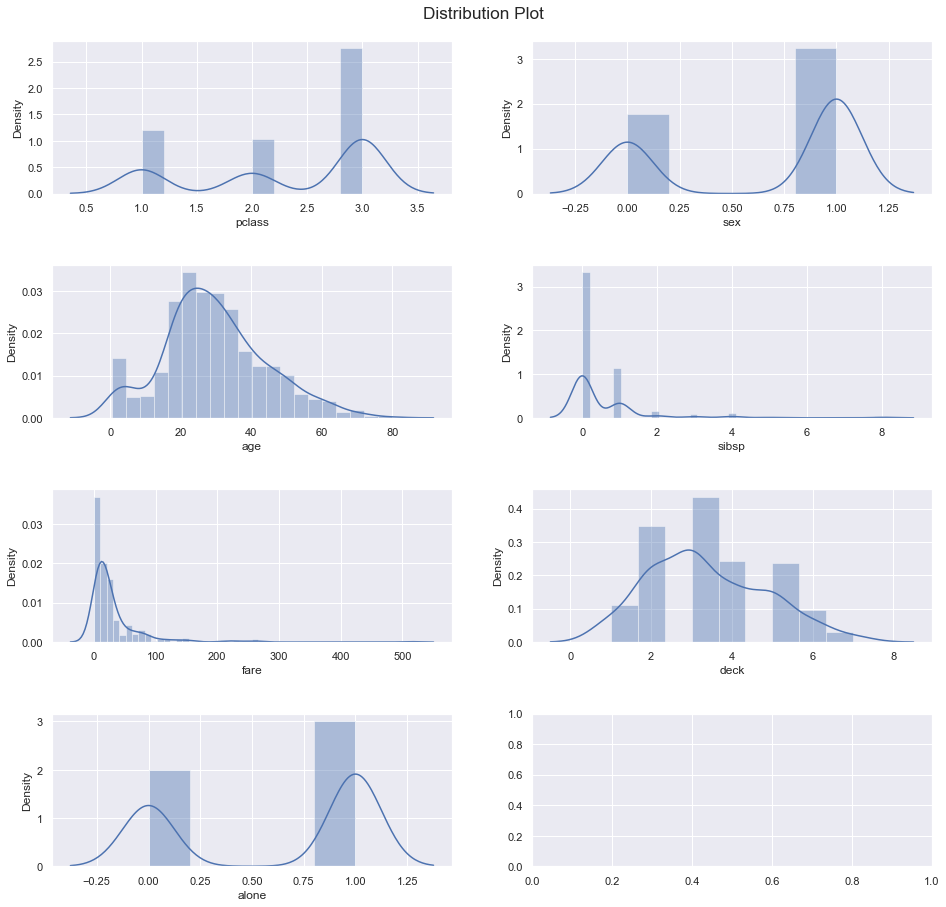

In [16]:
gimmeThemStats(ndf)

In [17]:
dfMeanMed = ndf.copy(deep = True)

In [18]:
dfMeanMed.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
fare          0
deck        688
alone         0
dtype: int64

In [19]:
dfMeanMed.kurt() - ndf.kurt()

survived    0.0
pclass      0.0
sex         0.0
age         0.0
sibsp       0.0
fare        0.0
deck        0.0
alone       0.0
dtype: float64

# As a general rule of thumb for SimpleImputer:
If skewness is less than -1 or greater than 1, the distribution is highly skewed

If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed

If skewness is between -0.5 and 0.5, the distribution is approximately symmetric

To determine for simple imputer if going to use Mean or Median or Mode to impute missing data

In [20]:
colsToFix = ['deck', 'age']
dfMeanMed[colsToFix].skew()

deck    0.418008
age     0.389108
dtype: float64

In [21]:
dfMeanMed.kurt() - ndf.kurt()

survived    0.0
pclass      0.0
sex         0.0
age         0.0
sibsp       0.0
fare        0.0
deck        0.0
alone       0.0
dtype: float64

# not going to use SimpleImputer because I am lazy to fill in NaN values in col "deck" and "age"

In [22]:
adf = ndf.copy(deep = True)

In [23]:
adf.head()

,survived,pclass,sex,age,sibsp,fare,deck,alone
0,0,3,1,22.0,1,7.2500,NaN,0
1,1,1,0,38.0,1,71.2833,3,0
2,1,3,0,26.0,0,7.9250,NaN,1
3,1,1,0,35.0,1,53.1000,3,0
4,0,3,1,35.0,0,8.0500,NaN,1


Now to choose the estimators and models for col:'deck' and 'age' 

estimator and models must be equal random_state will be set to 42

In [24]:
estimatorList = [
    ElasticNet(random_state=42),
    DecisionTreeRegressor(max_features='sqrt', random_state=42),
    ExtraTreesRegressor(n_estimators=10, random_state=42),
    RandomForestRegressor(criterion='mse', n_estimators=10, random_state=42),
    KNeighborsRegressor(n_neighbors=15)
]

imputation_styles = ['ascending', 'descending', 'roman', 'arabic', 'random']

classifications_list = [
    LinearSVC(C= 5.0, class_weight="balanced"), SVC(kernel='rbf'), GaussianNB(), 
    KNeighborsClassifier(n_neighbors=7), DecisionTreeClassifier(), RandomForestClassifier(),
    ExtraTreesClassifier(), AdaBoostClassifier(), GradientBoostingClassifier()
]

In [25]:
data = ml_def.imputeEm(adf, estimatorList, imputation_styles)

In [26]:
data[0]

['ElasticNet',
 'ElasticNet',
 'ElasticNet',
 'ElasticNet',
 'ElasticNet',
 'DecisionTreeRegressor',
 'DecisionTreeRegressor',
 'DecisionTreeRegressor',
 'DecisionTreeRegressor',
 'DecisionTreeRegressor',
 'ExtraTreesRegressor',
 'ExtraTreesRegressor',
 'ExtraTreesRegressor',
 'ExtraTreesRegressor',
 'ExtraTreesRegressor',
 'RandomForestRegressor',
 'RandomForestRegressor',
 'RandomForestRegressor',
 'RandomForestRegressor',
 'RandomForestRegressor',
 'KNeighborsRegressor',
 'KNeighborsRegressor',
 'KNeighborsRegressor',
 'KNeighborsRegressor',
 'KNeighborsRegressor']

In [27]:
data[1]

['ascending',
 'descending',
 'roman',
 'arabic',
 'random',
 'ascending',
 'descending',
 'roman',
 'arabic',
 'random',
 'ascending',
 'descending',
 'roman',
 'arabic',
 'random',
 'ascending',
 'descending',
 'roman',
 'arabic',
 'random',
 'ascending',
 'descending',
 'roman',
 'arabic',
 'random']

In [28]:
print(f"Estimator: {data[0][6]}")
print(f"Imputation order: {data[1][6]}")
data[2][6].head()

Estimator: DecisionTreeRegressor
Imputation order: descending


,survived,pclass,sex,age,sibsp,fare,deck,alone
0,0.0,3.0,1.0,22.0,1.0,7.2500,7.0,0.0
1,1.0,1.0,0.0,38.0,1.0,71.2833,3.0,0.0
2,1.0,3.0,0.0,26.0,0.0,7.9250,5.0,1.0
3,1.0,1.0,0.0,35.0,1.0,53.1000,3.0,0.0
4,0.0,3.0,1.0,35.0,0.0,8.0500,6.0,1.0


5 estimators and 5 imputation orders, I get a dataframe for each estimator and imputation order pair.
In total, 25 different dataframes.

In [29]:
len(data[2])

25

# now to check for negitive values 

In [30]:
ml_def.invalidNumberChecker(data)

# Yay no negitive values

# now to split data 4 ways 
X_train_list, X_test_list, y_train_list, y_test_list

In [31]:
X_train_list, X_test_list, y_train_list, y_test_list = ml_def.produceSplits(data)

In [32]:
print(f"The size of each X_train in X_train_list is {len(X_train_list[4])}")
print(f"The size of each X_test in X_test_list is {len(X_test_list[4])}")

The size of each X_train in X_train_list is 712
The size of each X_test in X_test_list is 179


In [33]:
X_train_list[7].head()

,pclass,sex,age,sibsp,fare,deck,alone
692,3.0,1.0,32.000000,0.0,56.4958,2.0,1.0
481,2.0,1.0,33.214286,0.0,0.0000,4.0,1.0
527,1.0,1.0,22.000000,0.0,221.7792,3.0,1.0
855,3.0,0.0,18.000000,0.0,9.3500,5.0,0.0
801,2.0,0.0,31.000000,1.0,26.2500,4.0,0.0


In [34]:
X_train_list[13].head()

,pclass,sex,age,sibsp,fare,deck,alone
692,3.0,1.0,26.000000,0.0,56.4958,4.7,1.0
481,2.0,1.0,43.116667,0.0,0.0000,5.2,1.0
527,1.0,1.0,24.000000,0.0,221.7792,3.0,1.0
855,3.0,0.0,18.000000,0.0,9.3500,6.0,0.0
801,2.0,0.0,31.000000,1.0,26.2500,5.9,0.0


In [35]:
scaled_train_dfs, scaled_test_dfs = ml_def.weightForMe(X_train_list, X_test_list)


In [36]:
scaled_train_dfs[6].head()

,pclass,sex,age,sibsp,fare,deck,alone
692,0.829568,0.742427,0.175491,-0.465084,0.513812,-1.725622,0.800346
481,-0.370945,0.742427,0.261775,-0.465084,-0.662563,-0.509445,0.800346
527,-1.571457,0.742427,-0.535085,-0.465084,3.955399,-1.117533,0.800346
855,0.829568,-1.346933,-0.819316,-0.465084,-0.467874,0.098644,-1.249460
801,-0.370945,-1.346933,0.104433,0.478335,-0.115977,-0.509445,-1.249460


In [37]:
classifications_list = [
    LinearSVC(C= 5.0, class_weight="balanced"), SVC(kernel='rbf'), GaussianNB(), 
    KNeighborsClassifier(n_neighbors=7), DecisionTreeClassifier(), RandomForestClassifier(),
    ExtraTreesClassifier(), AdaBoostClassifier(), GradientBoostingClassifier()
]

In [39]:
results = ml_def.acceptingModels(scaled_train_dfs, scaled_test_dfs, y_train_list, y_test_list, data, classifications_list)

In [43]:
results.head(20)

,ModelName,Estimator,Order,AccuracyScore,CorrectPredictionsCount,Total,PosPrecScore,PosRecScore,PosFScore,NegPrecScore,NegRecScore,NegFScore,TNPercentage,TPPercentage,FNPercentage,FPPercentage
0,LinearSVC,ElasticNet,ascending,0.810056,145,179.0,0.753623,0.753623,0.753623,0.845455,0.845455,0.845455,51.955307,29.050279,9.497207,9.497207
1,SVC,ElasticNet,ascending,0.810056,145,179.0,0.857143,0.608696,0.711864,0.792308,0.936364,0.858333,57.541899,23.463687,15.083799,3.910615
2,GaussianNB,ElasticNet,ascending,0.776536,139,179.0,0.723077,0.681159,0.701493,0.807018,0.836364,0.821429,51.396648,26.256983,12.290503,10.055866
3,KNeighborsClassifier,ElasticNet,ascending,0.815642,146,179.0,0.833333,0.652174,0.731707,0.808000,0.918182,0.859574,56.424581,25.139665,13.407821,5.027933
4,DecisionTreeClassifier,ElasticNet,ascending,0.821229,147,179.0,0.793651,0.724638,0.757576,0.836207,0.881818,0.858407,54.189944,27.932961,10.614525,7.262570
5,RandomForestClassifier,ElasticNet,ascending,0.832402,149,179.0,0.791045,0.768116,0.779412,0.857143,0.872727,0.864865,53.631285,29.608939,8.938547,7.821229
6,ExtraTreesClassifier,ElasticNet,ascending,0.832402,149,179.0,0.782609,0.782609,0.782609,0.863636,0.863636,0.863636,53.072626,30.167598,8.379888,8.379888
7,AdaBoostClassifier,ElasticNet,ascending,0.782123,140,179.0,0.720588,0.710145,0.715328,0.819820,0.827273,0.823529,50.837989,27.374302,11.173184,10.614525
8,GradientBoostingClassifier,ElasticNet,ascending,0.826816,148,179.0,0.839286,0.681159,0.752000,0.821138,0.918182,0.866953,56.424581,26.256983,12.290503,5.027933
9,LinearSVC,ElasticNet,descending,0.810056,145,179.0,0.753623,0.753623,0.753623,0.845455,0.845455,0.845455,51.955307,29.050279,9.497207,9.497207


In [41]:
len(results)

225

In [42]:
results.sort_values(by=['AccuracyScore'], ascending = False).head()

,ModelName,Estimator,Order,AccuracyScore,CorrectPredictionsCount,Total,PosPrecScore,PosRecScore,PosFScore,NegPrecScore,NegRecScore,NegFScore,TNPercentage,TPPercentage,FNPercentage,FPPercentage
103,DecisionTreeClassifier,ExtraTreesRegressor,descending,0.932961,167,179.0,0.925373,0.898551,0.911765,0.937500,0.954545,0.945946,58.659218,34.636872,3.910615,2.793296
121,DecisionTreeClassifier,ExtraTreesRegressor,arabic,0.932961,167,179.0,0.925373,0.898551,0.911765,0.937500,0.954545,0.945946,58.659218,34.636872,3.910615,2.793296
125,GradientBoostingClassifier,ExtraTreesRegressor,arabic,0.916201,164,179.0,0.935484,0.840580,0.885496,0.905983,0.963636,0.933921,59.217877,32.402235,6.145251,2.234637
107,GradientBoostingClassifier,ExtraTreesRegressor,descending,0.916201,164,179.0,0.935484,0.840580,0.885496,0.905983,0.963636,0.933921,59.217877,32.402235,6.145251,2.234637
104,RandomForestClassifier,ExtraTreesRegressor,descending,0.910615,163,179.0,0.884058,0.884058,0.884058,0.927273,0.927273,0.927273,56.983240,34.078212,4.469274,4.469274


In [45]:
display(results.groupby(['ModelName']).mean().sort_values(by=['AccuracyScore'], ascending = False).iloc[[0, 1, 2]])

,AccuracyScore,CorrectPredictionsCount,Total,PosPrecScore,PosRecScore,PosFScore,NegPrecScore,NegRecScore,NegFScore,TNPercentage,TPPercentage,FNPercentage,FPPercentage
ModelName,,,,,,,,,,,,,
GradientBoostingClassifier,0.854972,153.04,179.0,0.863944,0.738551,0.795551,0.850885,0.928000,0.887559,57.027933,28.469274,10.078212,4.424581
RandomForestClassifier,0.854302,152.92,179.0,0.827513,0.786087,0.806027,0.870107,0.897091,0.883306,55.128492,30.301676,8.245810,6.324022
ExtraTreesClassifier,0.852737,152.64,179.0,0.813691,0.801159,0.807269,0.876697,0.885091,0.880830,54.391061,30.882682,7.664804,7.061453


In [46]:
display(results.groupby(['Estimator']).mean().sort_values(by=['AccuracyScore'], ascending = False).iloc[[0]])

,AccuracyScore,CorrectPredictionsCount,Total,PosPrecScore,PosRecScore,PosFScore,NegPrecScore,NegRecScore,NegFScore,TNPercentage,TPPercentage,FNPercentage,FPPercentage
Estimator,,,,,,,,,,,,,
ExtraTreesRegressor,0.870888,155.888889,179.0,0.85299,0.807729,0.828645,0.883205,0.910505,0.896287,55.952824,31.13594,7.411546,5.49969


In [47]:
display(results.groupby(['Order']).mean().sort_values(by=['AccuracyScore'], ascending = False).iloc[[0]])

,AccuracyScore,CorrectPredictionsCount,Total,PosPrecScore,PosRecScore,PosFScore,NegPrecScore,NegRecScore,NegFScore,TNPercentage,TPPercentage,FNPercentage,FPPercentage
Order,,,,,,,,,,,,,
descending,0.834264,149.333333,179.0,0.810506,0.748792,0.77648,0.850191,0.887879,0.868023,54.562384,28.86406,9.683426,6.89013


In [48]:
# Sorting values by best positive recall score, then best negative recall score
display(results.groupby(['ModelName']).mean().sort_values(by=['PosRecScore', 'NegRecScore'], ascending = False).iloc[[0, 1]])

,AccuracyScore,CorrectPredictionsCount,Total,PosPrecScore,PosRecScore,PosFScore,NegPrecScore,NegRecScore,NegFScore,TNPercentage,TPPercentage,FNPercentage,FPPercentage
ModelName,,,,,,,,,,,,,
ExtraTreesClassifier,0.852737,152.64,179.0,0.813691,0.801159,0.807269,0.876697,0.885091,0.880830,54.391061,30.882682,7.664804,7.061453
DecisionTreeClassifier,0.843352,150.96,179.0,0.800935,0.790145,0.795295,0.869670,0.876727,0.873098,53.877095,30.458101,8.089385,7.575419


In [49]:
results.sort_values(by=['AccuracyScore']).head()

,ModelName,Estimator,Order,AccuracyScore,CorrectPredictionsCount,Total,PosPrecScore,PosRecScore,PosFScore,NegPrecScore,NegRecScore,NegFScore,TNPercentage,TPPercentage,FNPercentage,FPPercentage
205,AdaBoostClassifier,KNeighborsRegressor,roman,0.765363,137,179.0,0.695652,0.695652,0.695652,0.809091,0.809091,0.809091,49.72067,26.815642,11.731844,11.731844
187,AdaBoostClassifier,KNeighborsRegressor,ascending,0.765363,137,179.0,0.695652,0.695652,0.695652,0.809091,0.809091,0.809091,49.72067,26.815642,11.731844,11.731844
223,AdaBoostClassifier,KNeighborsRegressor,random,0.765363,137,179.0,0.695652,0.695652,0.695652,0.809091,0.809091,0.809091,49.72067,26.815642,11.731844,11.731844
196,AdaBoostClassifier,KNeighborsRegressor,descending,0.765363,137,179.0,0.701493,0.681159,0.691176,0.803571,0.818182,0.810811,50.27933,26.256983,12.290503,11.173184
214,AdaBoostClassifier,KNeighborsRegressor,arabic,0.765363,137,179.0,0.701493,0.681159,0.691176,0.803571,0.818182,0.810811,50.27933,26.256983,12.290503,11.173184


In [50]:
display(results.groupby(['ModelName']).mean().sort_values(by=['AccuracyScore']).iloc[[0, 1, 2]])

,AccuracyScore,CorrectPredictionsCount,Total,PosPrecScore,PosRecScore,PosFScore,NegPrecScore,NegRecScore,NegFScore,TNPercentage,TPPercentage,FNPercentage,FPPercentage
ModelName,,,,,,,,,,,,,
GaussianNB,0.785922,140.68,179.0,0.721962,0.723478,0.722460,0.826537,0.825091,0.825697,50.703911,27.888268,10.659218,10.748603
LinearSVC,0.811397,145.24,179.0,0.750765,0.764638,0.757584,0.850674,0.840727,0.845646,51.664804,29.474860,9.072626,9.787709
AdaBoostClassifier,0.816536,146.16,179.0,0.780222,0.733913,0.755904,0.838414,0.868364,0.852959,53.363128,28.290503,10.256983,8.089385


In [51]:
display(results.groupby(['Estimator']).mean().sort_values(by=['AccuracyScore']).iloc[[0]])

,AccuracyScore,CorrectPredictionsCount,Total,PosPrecScore,PosRecScore,PosFScore,NegPrecScore,NegRecScore,NegFScore,TNPercentage,TPPercentage,FNPercentage,FPPercentage
Estimator,,,,,,,,,,,,,
KNeighborsRegressor,0.803228,143.777778,179.0,0.769523,0.706924,0.734534,0.825286,0.863636,0.843285,53.072626,27.250155,11.297331,8.379888


In [52]:
display(results.groupby(['Order']).mean().sort_values(by=['AccuracyScore']).iloc[[0]])

,AccuracyScore,CorrectPredictionsCount,Total,PosPrecScore,PosRecScore,PosFScore,NegPrecScore,NegRecScore,NegFScore,TNPercentage,TPPercentage,FNPercentage,FPPercentage
Order,,,,,,,,,,,,,
random,0.829919,148.555556,179.0,0.804221,0.743961,0.770926,0.84707,0.883838,0.864453,54.314091,28.67784,9.869646,7.138423


In [53]:
# Sorting values by worst positive recall score, then worst negative recall score
display(results.groupby(['ModelName']).mean().sort_values(by=['PosRecScore', 'NegRecScore']).iloc[[0, 1]])

,AccuracyScore,CorrectPredictionsCount,Total,PosPrecScore,PosRecScore,PosFScore,NegPrecScore,NegRecScore,NegFScore,TNPercentage,TPPercentage,FNPercentage,FPPercentage
ModelName,,,,,,,,,,,,,
SVC,0.836872,149.80,179.0,0.880590,0.666667,0.758366,0.819040,0.943636,0.876835,57.988827,25.698324,12.849162,3.463687
GaussianNB,0.785922,140.68,179.0,0.721962,0.723478,0.722460,0.826537,0.825091,0.825697,50.703911,27.888268,10.659218,10.748603


In [54]:
# Sorting values by worst negative recall score, then worst positive recall score
display(results.groupby(['ModelName']).mean().sort_values(by=['NegRecScore', 'PosRecScore']).iloc[[0, 1]])

,AccuracyScore,CorrectPredictionsCount,Total,PosPrecScore,PosRecScore,PosFScore,NegPrecScore,NegRecScore,NegFScore,TNPercentage,TPPercentage,FNPercentage,FPPercentage
ModelName,,,,,,,,,,,,,
GaussianNB,0.785922,140.68,179.0,0.721962,0.723478,0.722460,0.826537,0.825091,0.825697,50.703911,27.888268,10.659218,10.748603
LinearSVC,0.811397,145.24,179.0,0.750765,0.764638,0.757584,0.850674,0.840727,0.845646,51.664804,29.474860,9.072626,9.787709
